# Forecasting - Facebook Prophet
https://facebook.github.io/prophet/

https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/

https://peerj.com/preprints/3190.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fbprophet import Prophet

%matplotlib inline
plt.style.use('fivethirtyeight')

# Trivial Forecast (rolling mean)

In [2]:
df = pd.DataFrame({'X': np.arange(0, 10)}) # gernate an input df
df['y'] = df.rolling(3).mean() # take the window and write the average as the result
df.head()

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0


In [3]:
df


,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


# Small data set

In [4]:
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv', sep=';')
df_all.head()
df = df_all[['date','Germany']]
df = df.rename(columns={'date': 'ds', 'Germany': 'y'})

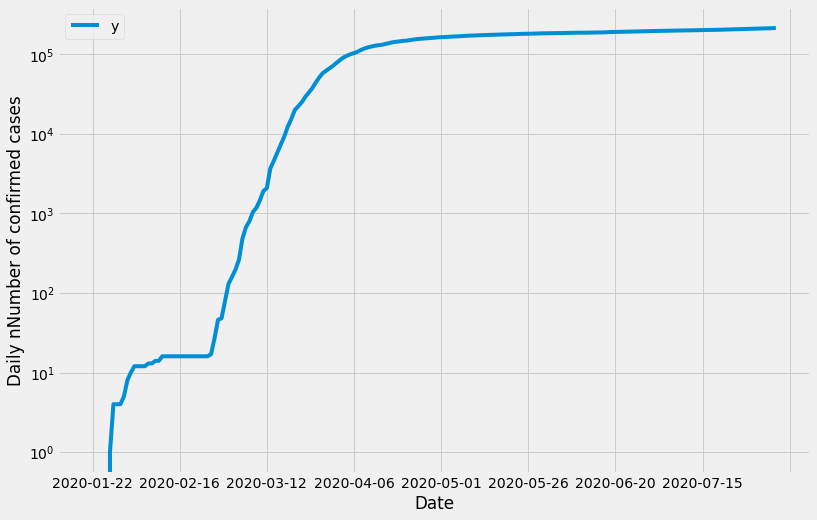

In [5]:
ax = df.set_index('ds').plot(figsize=(12,8), logy=True)
ax.set_ylabel('Daily nNumber of confirmed cases')
ax.set_xlabel('Date')

plt.show()

In [6]:
# set the uncertainty intervval to 95% (Prophet default is 80%)
#my_model = Prophet(interval_width=0.95)
my_model = Prophet(growth='logistic')
df['cap'] = 1000000
my_model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [7]:
future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap'] = 1000000
df.tail()

,ds,y,cap
192,2020-08-01,211005,1000000
193,2020-08-02,211220,1000000
194,2020-08-03,212111,1000000
195,2020-08-04,212828,1000000
196,2020-08-05,214113,1000000


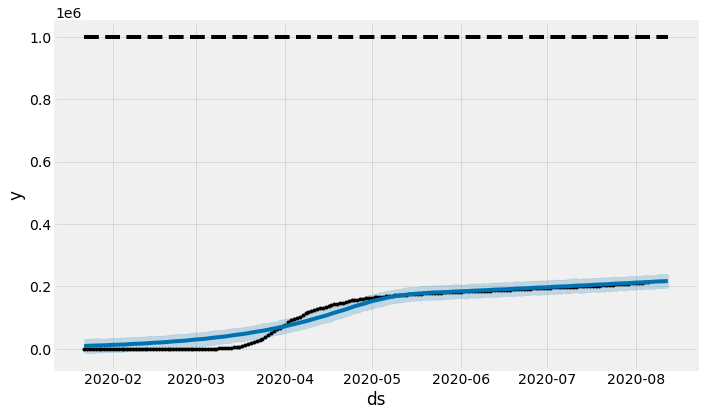

In [8]:
forecast = my_model.predict(future_dates)
my_model.plot(forecast, uncertainty=True); # since fbprophet is rendering the output

In [9]:
import plotly.offline as py
from fbprophet.plot import plot_plotly
py.init_notebook_mode(connected=True)

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [10]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,9332.852903,1000000,-11362.587045,31870.984234,9332.852903,9332.852903,-313.481969,-313.481969,-313.481969,-313.481969,-313.481969,-313.481969,0.0,0.0,0.0,9019.370934
1,2020-01-23,9617.228102,1000000,-12863.842503,31153.332170,9617.228102,9617.228102,-58.275122,-58.275122,-58.275122,-58.275122,-58.275122,-58.275122,0.0,0.0,0.0,9558.952980
2,2020-01-24,9910.181629,1000000,-13387.614454,34078.393864,9910.181629,9910.181629,281.836461,281.836461,281.836461,281.836461,281.836461,281.836461,0.0,0.0,0.0,10192.018090
3,2020-01-25,10211.966895,1000000,-14832.637293,32519.809924,10211.966895,10211.966895,246.155539,246.155539,246.155539,246.155539,246.155539,246.155539,0.0,0.0,0.0,10458.122434
4,2020-01-26,10522.844466,1000000,-12431.254447,34126.577229,10522.844466,10522.844466,77.474769,77.474769,77.474769,77.474769,77.474769,77.474769,0.0,0.0,0.0,10600.319235


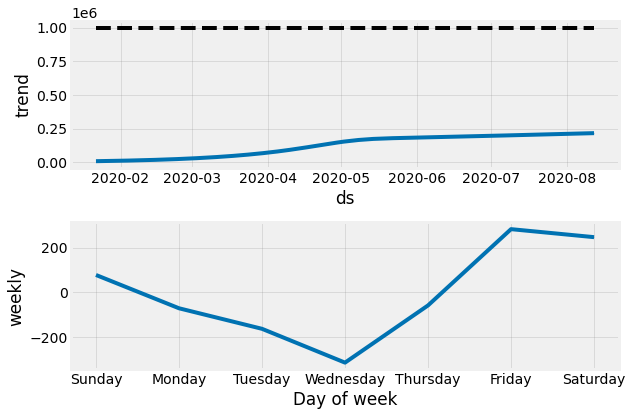

In [11]:
my_model.plot_components(forecast);

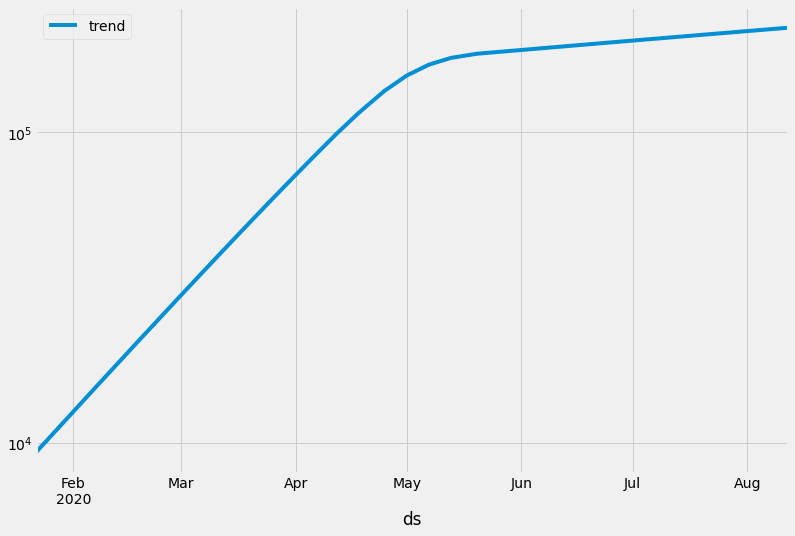

In [12]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

In [13]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='30 days', # we take the first 30 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future
df_cv.head()

INFO:fbprophet:Making 160 forecasts with cutoffs between 2020-02-21 00:00:00 and 2020-07-29 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,21.994557,18.145535,25.770246,16,2020-02-21
1,2020-02-23,23.425093,19.214103,27.280608,16,2020-02-21
2,2020-02-24,24.892725,20.692394,28.853737,16,2020-02-21
3,2020-02-25,26.899455,22.854204,30.803017,17,2020-02-21
4,2020-02-26,26.725895,22.985148,30.651120,27,2020-02-21


In [14]:
df_cv.sort_values(by=['cutoff', 'ds'])[0:14]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-22,21.994557,18.145535,25.770246,16,2020-02-21
1,2020-02-23,23.425093,19.214103,27.280608,16,2020-02-21
2,2020-02-24,24.892725,20.692394,28.853737,16,2020-02-21
3,2020-02-25,26.899455,22.854204,30.803017,17,2020-02-21
4,2020-02-26,26.725895,22.985148,30.651120,27,2020-02-21
5,2020-02-27,27.648088,23.746770,31.423484,46,2020-02-21
6,2020-02-28,29.020542,25.102493,33.096323,48,2020-02-21
7,2020-02-23,22.392416,18.270335,26.143416,16,2020-02-22
8,2020-02-24,23.770010,19.662846,27.902799,16,2020-02-22
9,2020-02-25,25.680020,21.553691,29.764831,17,2020-02-22


In [15]:
df[['ds', 'y']][30:]

,ds,y
30,2020-02-21,16
31,2020-02-22,16
32,2020-02-23,16
33,2020-02-24,16
34,2020-02-25,17
...,...,...
192,2020-08-01,211005
193,2020-08-02,211220
194,2020-08-03,212111
195,2020-08-04,212828


In [16]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

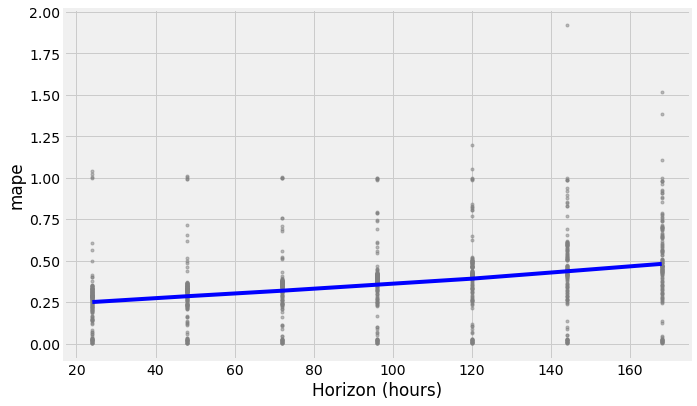

In [17]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

# Diagonalplot 

### gives a good understanding for the under and over estimation w.r.t. magnitude 

In [18]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [19]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
1091,2020-08-01,214758.356711,187312.504900,242661.976047,211005,2020-07-25,7 days
1098,2020-08-02,209439.266069,189788.557870,229266.812270,211220,2020-07-26,7 days
1105,2020-08-03,214792.813667,191594.021748,238198.931269,212111,2020-07-27,7 days
1112,2020-08-04,210726.548944,191529.113387,230330.110835,212828,2020-07-28,7 days
1119,2020-08-05,210819.493753,188706.514523,234549.849808,214113,2020-07-29,7 days


In [20]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

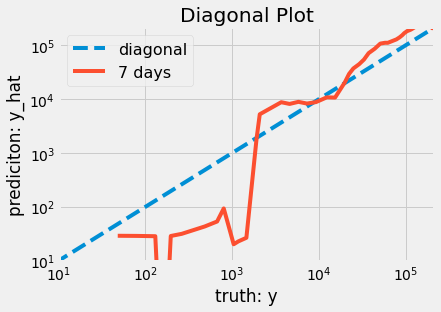

In [21]:

fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

# Trivial Forecast

 Example trivial forecast, prediciton 7 days into the future

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

### One of the standard forecast is a rolling mean 

An other standard forecast is the exponentially-weighted moving average,
see pandas.ewma

In [24]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean() # take the average of 3 days

In [26]:
# the result has to be shifted according to the prediciton horizon (here 7 days)

df_trivial['cutoff']  = df_trivial['ds'].shift(7)
df_trivial['y_hat']   = df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon'] = df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial.head()

MAPE: 153.72898014202116


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.0,NaT,NaN,NaT
3,2020-01-25,0,0.0,NaT,NaN,NaT
4,2020-01-26,0,0.0,NaT,NaN,NaT
